# 케라스 창시자에게 배우는 딥러닝 Main Quest
---
## U-Net 이미지 세그멘테이션
---
### Pascal-voc-2012 데이터 불러오기

In [1]:
import datasets
from datasets import load_dataset

dataset = load_dataset('nateraw/pascal-voc-2012', split = 'train')

Using custom data configuration nateraw___pascal-voc-2012-c68607404d4811ac
Reusing dataset parquet (/aiffel/.cache/huggingface/datasets/parquet/nateraw___pascal-voc-2012-c68607404d4811ac/0.0.0/9296ce43568b20d72ff8ff8ecbc821a16b68e9b8b7058805ef11f06e035f911a)


In [2]:
dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 2913
})

### 데이터 전처리
#### Augmentation 적용 및 정규화 텐서 반환 함수 및 시각화 확인

(256, 256, 3) (256, 256, 3)


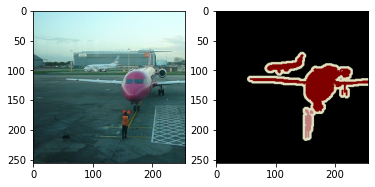

(256, 256, 3) (256, 256, 3)


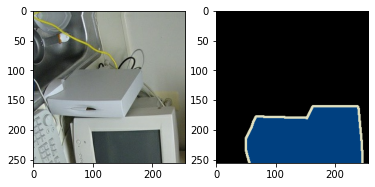

(256, 256, 3) (256, 256, 3)


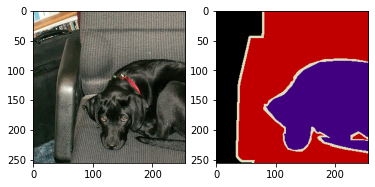

(256, 256, 3) (256, 256, 3)


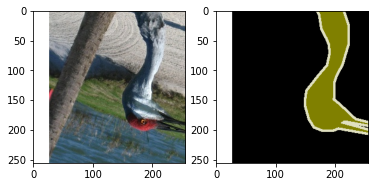

(256, 256, 3) (256, 256, 3)


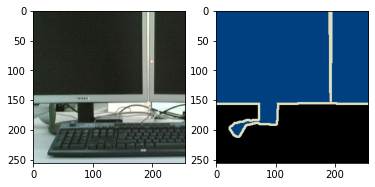

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.utils import load_img, img_to_array

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def bytes_to_normalized(data):
    img = image.decode_image(data, 3)        
    return normalize(img)

def apply_augmentation(org, mask):
    # 역방향 축으로 이미지(텐서) 결합
    stacked = tf.concat([org, mask], axis=-1)
    
    # 랜덤으로 REFLECT 또는 CONSTANT 모드를 지정하여 30픽셀 만큼 패딩
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # 256*256*6 크기로 랜덤으로 자르기
    out = image.random_crop(padded, size=[256, 256, 6])
    # 무작위로 좌우 반전
    out = image.random_flip_left_right(out)
    # 무작위로 상하 반전
    out = image.random_flip_up_down(out)
    # 무작위 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

def get_data(ds, show=False):
    org = bytes_to_normalized(ds['image']['bytes'])
    mask = bytes_to_normalized(ds['mask']['bytes'])
    org, mask = apply_augmentation(org, mask)
    if show:
        print(org.shape, mask.shape)
        plt.subplot(1,2,1); plt.imshow(denormalize(org))
        plt.subplot(1,2,2); plt.imshow(denormalize(mask))        
        plt.show()
    return org, mask

for i in range(5):
    org, mask = get_data(dataset[i], True)

In [4]:
img_size = (256, 256)
num_data = len(dataset)

input_imgs = np.zeros((num_data,) + img_size + (3,), dtype='float32')
target_imgs = np.zeros((num_data,) + img_size + (1,), dtype='uint8')

del_idx = []
for i in range(num_data):
    try:
        org, mask = get_data(dataset[i])
        grayscale = image.rgb_to_grayscale(denormalize(mask))
        
        input_imgs[i] = org
        target_imgs[i] = grayscale
    except:
        print('except index: ',i)
        del_idx.append(i)
    

except index:  750
except index:  910
except index:  1592
except index:  1612
except index:  1918
except index:  1958


In [5]:
# exception 데이터 삭제 : 256 * 256 보다 작은 이미지
inputs = np.delete(input_imgs, tuple(del_idx), axis=0)
targets = np.delete(target_imgs, tuple(del_idx), axis=0)
    
print(num_data, len(inputs), len(targets))

2913 2907 2907


In [6]:
# 검증 데이터 분리
num_val = 300
train_inputs = inputs[:-num_val]
train_targets = targets[:-num_val]
val_inputs = inputs[-num_val:]
val_targets = targets[-num_val:]

In [7]:
print(len(train_inputs), len(val_inputs))
print(len(train_targets), len(val_targets))

target_set = set(targets.flatten())


2607 300
2607 300


---
### 모델 생성

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # Contracting Path (Left side of U-Net)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottom of U-Net
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    
    # Expansive Path (Right side of U-Net)
    up6 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 모델 생성
input_shape = (256, 256, 3)  # 입력 이미지 크기
num_classes = len(target_set)  # 세그멘테이션 클래스 수
model = unet_model(input_shape, num_classes)

# 모델 요약 출력
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### 컴파일 및 학습

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

optimizer = Adam(learning_rate=0.001)
loss_fn = SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])



In [ ]:
callbacks = [
    ModelCheckpoint('./u-net_image_segmentation.h5', save_best_only=True)
]
history = model.fit(train_inputs, train_targets, callbacks = callbacks, batch_size=30, validation_data=(val_inputs, val_targets))


48/87 [===============>..............] - ETA: 24s - loss: nan - accuracy: 0.5868